# Part 2: Generalization across subjects
### Import required libraries

In [15]:
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, pairwise_distances, f1_score, r2_score    
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression
from scipy import stats

from functions import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2.1. Visualize and preprocess the data
### Load and extract data

In [16]:
# Define the base path to the zip files and the extraction directory
base_zip_path = extraction_dir = '../data/'
figure_dir = '../output/Part 2/'
n_subjects = 27
id_column, emg, stimulus, repetition = load_and_concatenate_subjects(base_path=base_zip_path, extraction_dir=extraction_dir, n_subjects=n_subjects, isZipped=False)

### Exploration of the data

In [17]:
# Print the shape of the data and labels
print("EMG:", emg.shape)
print("Stimulus:", stimulus.shape)
print("Repetition:", repetition.shape)
print(f"There are {emg.shape[0]} timepoints and {emg.shape[1]} channels.")

n_stimuli = len(np.unique(stimulus)) - 1 # -1 because 0 is the resting condition
n_repetitions = len(np.unique(repetition)) - 1 # -1 because 0 is not a repetition
print(f'There are {n_stimuli} types of movement and {n_repetitions} repetitions for {n_subjects} subjects.')

EMG: (2731393, 10)
Stimulus: (2731393, 1)
Repetition: (2731393, 1)
There are 2731393 timepoints and 10 channels.
There are 12 types of movement and 10 repetitions for 27 subjects.


### Visualize raw EMG data

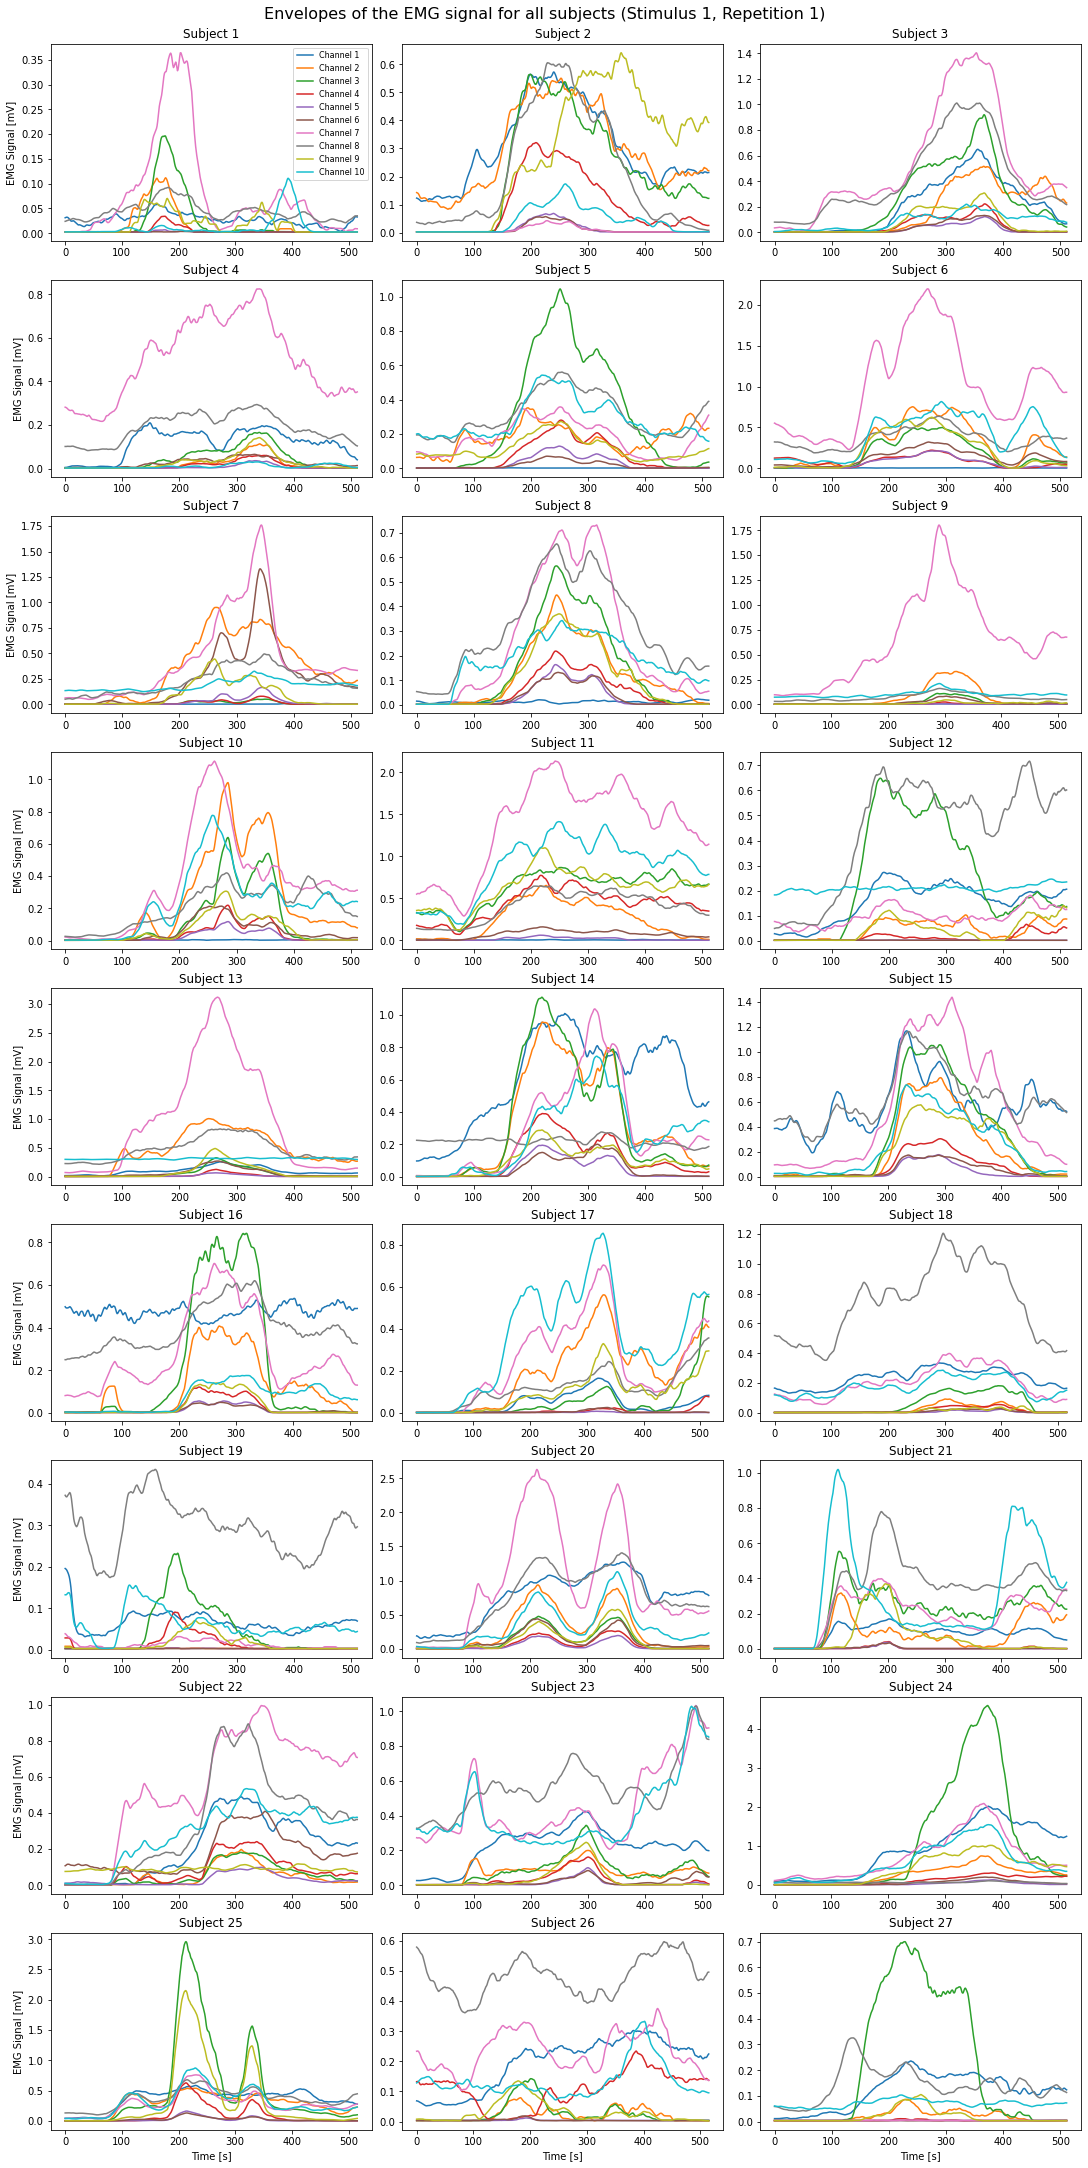

In [18]:
plot_emg_envelopes(emg, id_column, stimulus, repetition, n_stimuli, n_repetitions)

### Preprocess EMG data

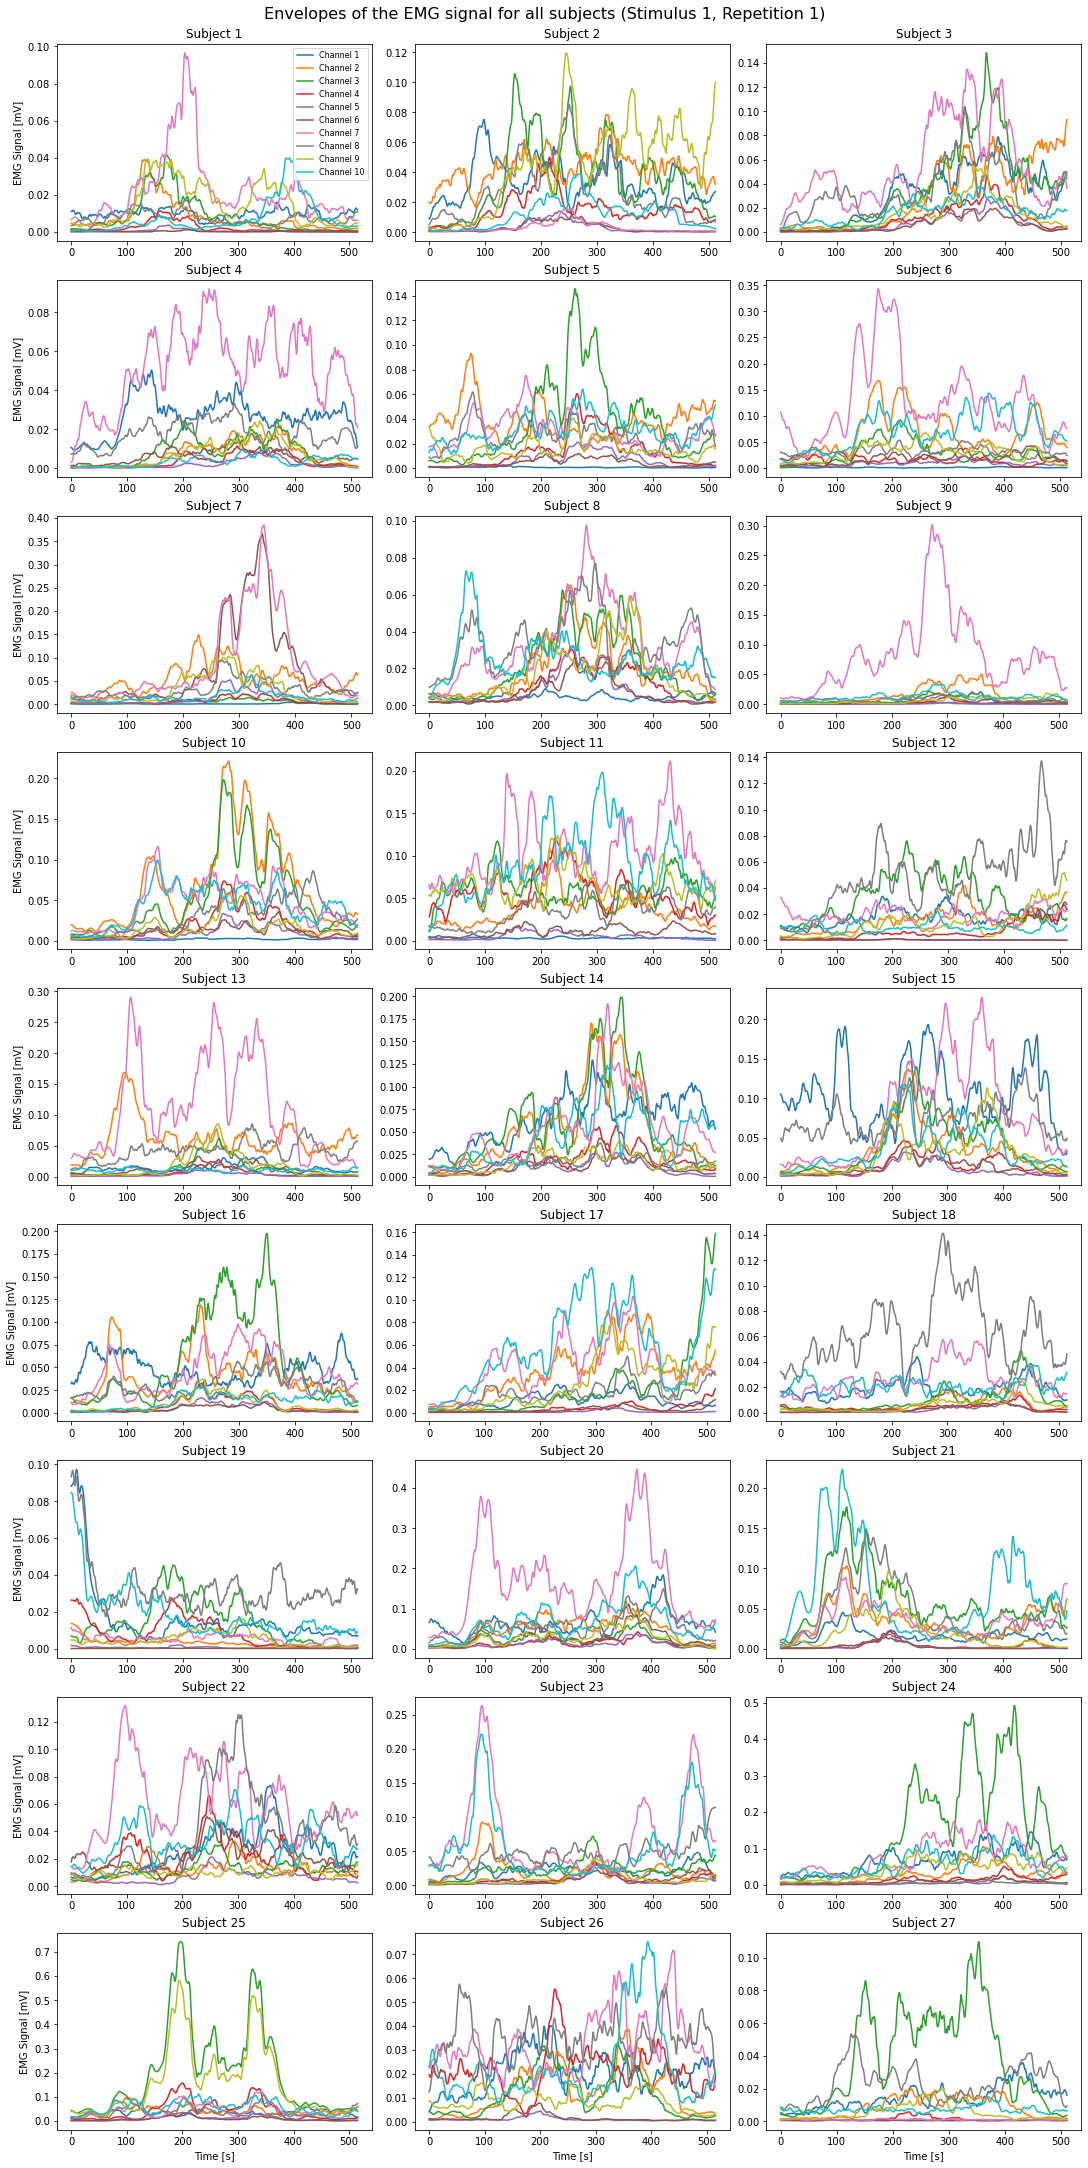

In [19]:
# Apply bandpass filter to the data
emg_filtered = bandpass_filter(emg)

# Rectify the signal
emg_rectified = np.abs(emg_filtered)

# Use the rectified signal as input to the plotting function
plot_emg_envelopes(emg_rectified, id_column, stimulus, repetition, n_stimuli, n_repetitions, filtered=True)

## 2.2. Feature Extraction

In [20]:
# Build the dataset and labels
dataset, labels, subject_id_column = build_dataset_from_ninapro_all_subjects(
    subject_id_column=id_column,
    emg=emg_rectified,
    stimulus=stimulus,
    repetition=repetition,
    features=[mav, std, maxav, rms, wl, ssc, dft_energy, median_frequency],
)

print(f"Dataset dimension: {dataset.shape}")
print(f"Labels dimension: {labels.shape}")
print(f"Subject ID column dimension: {subject_id_column.shape}")
feature_names = ['MAV', 'STD', 'MaxAV', 'RMS', 'WL', 'SSC', 'DFT Energy', 'Median Frequency']

Dataset dimension: (3240, 80)
Labels dimension: (3240,)
Subject ID column dimension: (3240,)


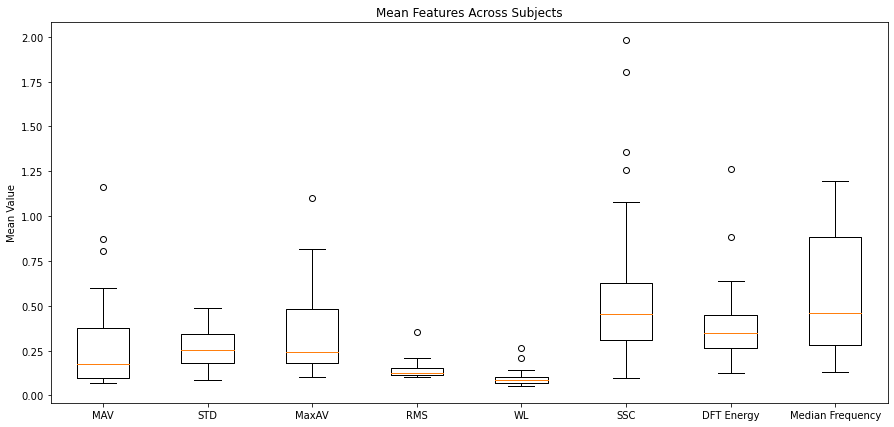

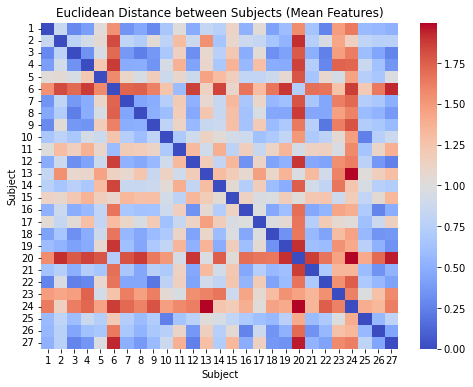

In [21]:
# Get unique subjects
unique_subjects = np.unique(subject_id_column).astype(int)
num_trials = 10 
n_features = int(dataset.shape[1] / num_trials)

# Initialize arrays to store the mean and std for each feature and subject
means_subjects = np.zeros((len(unique_subjects), n_features))
stds_subjects = np.zeros((len(unique_subjects), n_features))

# Reshape dataset for each subject's feature across trials
for i, subject in enumerate(unique_subjects):
    subject_mask = subject_id_column == subject
    emg_subject = dataset[subject_mask]  # Select the rows corresponding to the current subject
    # Reshape: Each feature will be grouped across trials for the current subject
    for feature_idx in range(n_features):
        feature_data = emg_subject[:, feature_idx*num_trials:(feature_idx+1)*num_trials]  # Select data for one feature
        means_subjects[i, feature_idx] = np.mean(feature_data)  # Mean across trials for the feature
        stds_subjects[i, feature_idx] = np.std(feature_data)    # Standard deviation across trials for the feature

# Visualize the mean and standard deviation of features across subjects
plt.figure(figsize=(15, 7))
plt.title('Mean Features Across Subjects')
plt.boxplot(means_subjects, labels=feature_names)
plt.ylabel('Mean Value')
plt.savefig(figure_dir + 'mean_features.png')
plt.show()

# Compare similarity across subjects using Euclidean distance
distances = pairwise_distances(means_subjects, metric='euclidean')

# Visualize the Euclidean distance matrix between subjects
plt.figure(figsize=(8, 6))
sns.heatmap(distances, cmap='coolwarm', xticklabels=unique_subjects, yticklabels=unique_subjects)
plt.title("Euclidean Distance between Subjects (Mean Features)")
plt.xlabel("Subject")
plt.ylabel("Subject")
plt.savefig(figure_dir + 'euclidean_distance.png')
plt.show()

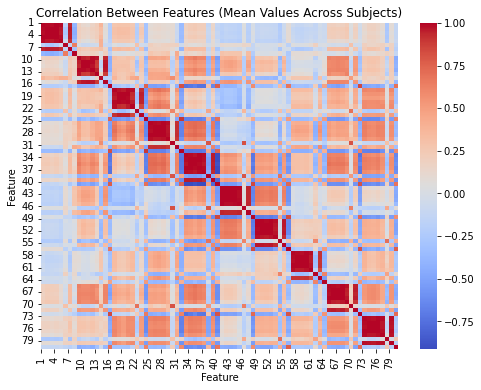

In [22]:
n_features = dataset.shape[1]

# Initialize arrays to store the mean and std for each feature and subject
means_subjects = np.zeros((len(unique_subjects), n_features))
stds_subjects = np.zeros((len(unique_subjects), n_features))

# Calculate mean and std for each feature per subject
for i, subject in enumerate(unique_subjects):
    subject_mask = subject_id_column == subject
    means_subjects[i] = np.mean(dataset[subject_mask], axis=0)
    stds_subjects[i] = np.std(dataset[subject_mask], axis=0)

# Optionally, you can also check correlation across subjects for each feature
correlation_matrix = np.corrcoef(means_subjects, rowvar=False)

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', xticklabels=np.arange(1, n_features + 1), yticklabels=np.arange(1, n_features + 1))
plt.title("Correlation Between Features (Mean Values Across Subjects)")
plt.xlabel("Feature")
plt.ylabel("Feature")
plt.xticks(ticks=np.arange(0, n_features, 3), labels=np.arange(1, n_features + 1, 3))
plt.yticks(ticks=np.arange(0, n_features, 3), labels=np.arange(1, n_features + 1, 3))
plt.savefig(figure_dir + 'correlation_features.png')
plt.show()

## 2.3. Train a classification model

In [23]:
# Create train from the first 26 subject and test with the last subejct
X_train = dataset[subject_id_column != 27]
y_train = labels[subject_id_column != 27]

X_test = dataset[subject_id_column == 27]
y_test = labels[subject_id_column == 27]

# Normalizing the data
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_test_z = scaler.transform(X_test)

# Train RandomForest classifier on the normalized data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_z, y_train)

RandomForestClassifier(random_state=42)

F1 score: 0.07


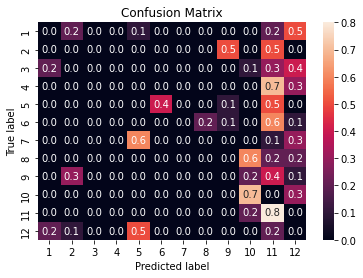

In [24]:
# Perform cross-validation and get predictions
y_pred_cv = clf.predict(X_test_z)

# Calculate the confusion matrix
confmat = confusion_matrix(y_test, y_pred_cv, normalize="true")

# Calculate the F1 score for the classifier
f1score = f1_score(y_test, y_pred_cv, average="weighted")

# Print the f1 score
print(f"F1 score: {f1score:.2f}")

# Plot the confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, fmt=".1f", ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
ax.set_xticklabels(range(1, len(confmat) + 1))
ax.set_yticklabels(range(1, len(confmat) + 1))
plt.title("Confusion Matrix")
plt.savefig(figure_dir + 'confusion_matrix.png')
plt.show()

## 2.4. Rotate the subject used for testing

Subject used for testing : 1 - F1 score : 0.23783170533170533
Subject used for testing : 2 - F1 score : 0.06112235717498875
Subject used for testing : 3 - F1 score : 0.26135599572465695
Subject used for testing : 4 - F1 score : 0.35314993253369026
Subject used for testing : 5 - F1 score : 0.29930687074649925
Subject used for testing : 6 - F1 score : 0.17521486797802588
Subject used for testing : 7 - F1 score : 0.16830682974229946
Subject used for testing : 8 - F1 score : 0.2366368894574382
Subject used for testing : 9 - F1 score : 0.09698960043787631
Subject used for testing : 10 - F1 score : 0.349332620652224
Subject used for testing : 11 - F1 score : 0.22030883060294826
Subject used for testing : 12 - F1 score : 0.19216756047825656
Subject used for testing : 13 - F1 score : 0.17031476242002558
Subject used for testing : 14 - F1 score : 0.2369476498733465
Subject used for testing : 15 - F1 score : 0.2865107050572167
Subject used for testing : 16 - F1 score : 0.33299364296172324
Subjec

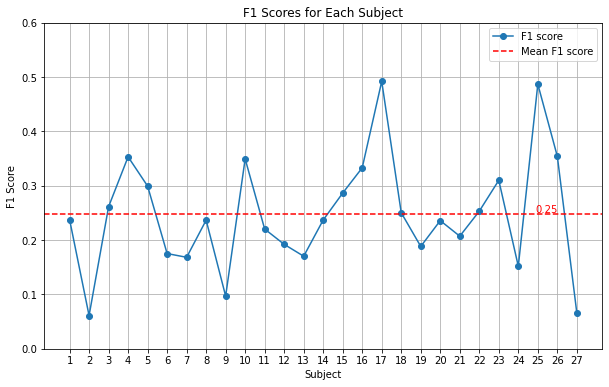

In [25]:
f1_scores = []

# Rotate the subject used for testing
for subject in range(1, 28):
    X_train = dataset[subject_id_column != subject]
    y_train = labels[subject_id_column != subject]

    X_test = dataset[subject_id_column == subject]
    y_test = labels[subject_id_column == subject]

    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)

    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_z, y_train)

    y_pred = clf.predict(X_test_z)
    f1Score = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1Score)

    print(f"Subject used for testing : {subject} - F1 score : {f1Score}")

# Plot the F1 scores for each subject
mean_f1 = np.mean(f1_scores)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 28), f1_scores, marker='o', label='F1 score')
plt.text(len(f1_scores) - 1, mean_f1, f'{mean_f1:.2f}', color='r', ha='right', va='bottom')
plt.axhline(mean_f1, color='r', linestyle='--', label='Mean F1 score')
plt.title('F1 Scores for Each Subject')
plt.xlabel('Subject')
plt.ylabel('F1 Score')
plt.ylim(0, 0.6)
plt.xticks(range(1, 28))
plt.legend()
plt.grid(True)
plt.savefig(figure_dir + 'f1_scores_for_each_subject.png')
plt.show()

## 2.5. Vary the number of subjects in the training set

In [26]:
f1_scores = []
# Rotate the subject used for testing
for subject in range(1, 27):
    X_train = dataset[subject_id_column <= subject]
    y_train = labels[subject_id_column <= subject]

    X_test = dataset[subject_id_column == 27]
    y_test = labels[subject_id_column == 27]

    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)

    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_z, y_train)

    y_pred = clf.predict(X_test_z)
    f1Score = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1Score)
    print(f"{subject} Subjects used for training - F1 score when predicting subject 27 : {f1Score}")

1 Subjects used for training - F1 score when predicting subject 27 : 0.035622000738279806
2 Subjects used for training - F1 score when predicting subject 27 : 0.04501262626262626
3 Subjects used for training - F1 score when predicting subject 27 : 0.09012025012025013
4 Subjects used for training - F1 score when predicting subject 27 : 0.05609324395571289
5 Subjects used for training - F1 score when predicting subject 27 : 0.025235404896421842
6 Subjects used for training - F1 score when predicting subject 27 : 0.030180840664711626
7 Subjects used for training - F1 score when predicting subject 27 : 0.03408602150537634
8 Subjects used for training - F1 score when predicting subject 27 : 0.051375994694960216
9 Subjects used for training - F1 score when predicting subject 27 : 0.0368093503339405
10 Subjects used for training - F1 score when predicting subject 27 : 0.08038914490527395
11 Subjects used for training - F1 score when predicting subject 27 : 0.0832230349471729
12 Subjects used 

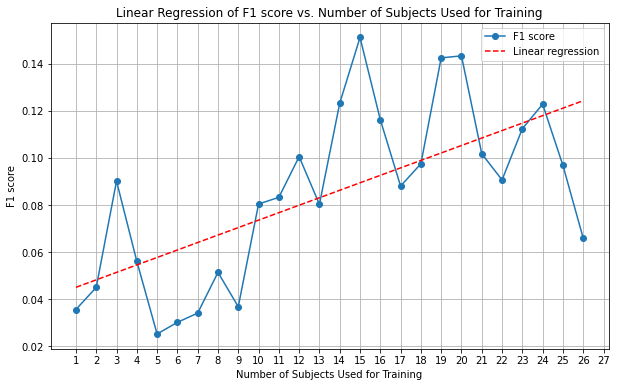


Equation of the linear regression line: y = 0.0032x + 0.0419
R^2 score: 0.4261503197750951


In [27]:
subject_range = range(1, 27)  # Subjects from 1 to 26
# 1. **Linear Regression to test for statistical increase**
X = np.array(subject_range).reshape(-1, 1)  # Number of subjects
y = np.array(f1_scores)  # Corresponding accuracies

# Fit a linear regression model
regressor = LinearRegression()
regressor.fit(X, y)

# Get the regression line
y_pred_regression = regressor.predict(X)

# Plot the linear regression result
plt.figure(figsize=(10, 6))
plt.plot(subject_range, f1_scores, marker='o', label='F1 score')
plt.plot(subject_range, y_pred_regression, color='r', linestyle='--', label='Linear regression')
plt.title("Linear Regression of F1 score vs. Number of Subjects Used for Training")
plt.xlabel("Number of Subjects Used for Training")
plt.ylabel("F1 score")
plt.xticks(range(1, 28))
plt.legend()
plt.grid(True)
plt.savefig(figure_dir + 'linear_regression_f1_score_number_subjects.png')
plt.show()

# Regression coefficient and intercept
slope = regressor.coef_[0]
intercept = regressor.intercept_
print(f"\nEquation of the linear regression line: y = {slope:.4f}x + {intercept:.4f}")
print(f"R^2 score: {r2_score(y, y_pred_regression)}")